# Monte Carlo Control with Exploring Starts

The goal is to find the optimal policy $\pi_*$ by learning the action-value function $q_*(s,a)$ using Monte Carlo methods. Unlike MC Prediction which evaluates a fixed policy, MC Control improves the policy iteratively.

The **Exploring Starts** assumption allows us to start episodes from any state-action pair, ensuring all state-action pairs are visited infinitely often in the limit.

[<img src="../Pseudocodes/mc_control_with_es.png" width="600"/>](../Pseudocodes/mc_control_with_es.png)

**Key differences from MC Prediction:**
- Learn Q(s,a) instead of V(s)
- Improve policy greedily: $\pi(s) = \arg\max_a Q(s,a)$
- Use first-visit MC for state-action pairs
- Randomly choose initial state and action for each episode

In this notebook, we will find the optimal Blackjack strategy using MC Control with Exploring Starts.

In [12]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import sys

from collections import defaultdict

In [13]:
blackjack_env = gym.make("Blackjack-v1", natural=False, sab=False)

In [14]:
def mc_control_es(env, num_eps, gamma=1.0):
    """
    Monte Carlo control with Exploring Starts algorithm.
    
    Args:
        env: environment
        num_eps: number of episodes to run
        gamma: discount factor
    
    Returns:
        Q: action-value function
        pi: optimal policy
    """
    # Initialize Q(s,a) arbitrarily and Returns(s,a) as empty lists
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    returns = defaultdict(list)
    
    # Initialize policy arbitrarily (will be improved iteratively)
    pi = defaultdict(lambda: np.random.randint(0, env.action_space.n))
    
    for eps in range(1, num_eps + 1):
        if eps % 10000 == 0:
            print(f"\rEpisode {eps}/{num_eps}", end="")
            sys.stdout.flush()
        
        # Reset environment first
        state, _ = env.reset()
        episode = []
        
        # Exploring Starts: Use random action for first step to ensure exploration
        # This simulates the exploring starts assumption by ensuring we don't always
        # follow the current policy from the very beginning
        action = np.random.randint(0, env.action_space.n)
        next_state, reward, terminated, truncated, _ = env.step(action)
        episode.append((state, action, reward))
        
        if not (terminated or truncated):
            state = next_state
        
        # Continue episode following current policy
        while not (terminated or truncated):
            action = pi[state]
            next_state, reward, terminated, truncated, _ = env.step(action)
            episode.append((state, action, reward))
            
            if not (terminated or truncated):
                state = next_state
        
        # Calculate returns and update Q for first visits
        G = 0
        visited_state_actions = set()
        
        # Process episode in reverse order
        for t in reversed(range(len(episode))):
            state, action, reward = episode[t]
            G = gamma * G + reward
            
            # First-visit MC: only update if this is the first time we see this state-action pair
            if (state, action) not in visited_state_actions:
                visited_state_actions.add((state, action))
                returns[(state, action)].append(G)
                Q[state][action] = np.mean(returns[(state, action)])
                
                # Policy improvement: make policy greedy with respect to Q
                pi[state] = np.argmax(Q[state])
    
    return Q, pi


In [15]:
def plot_q_values(Q):
    """
    Plot Q-values as heatmaps for both actions and both ace conditions.
    
    Args:
        Q: action-value function
    """
    # Separate Q-values by action and ace condition
    q_stick_no_ace = {}
    q_stick_ace = {}
    q_hit_no_ace = {}
    q_hit_ace = {}
    
    for state, q_values in Q.items():
        player_sum, dealer_card, usable_ace = state
        if usable_ace:
            q_stick_ace[(player_sum, dealer_card)] = q_values[0]  # stick
            q_hit_ace[(player_sum, dealer_card)] = q_values[1]    # hit
        else:
            q_stick_no_ace[(player_sum, dealer_card)] = q_values[0]  # stick
            q_hit_no_ace[(player_sum, dealer_card)] = q_values[1]    # hit
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot Q(s, stick) without usable ace
    if q_stick_no_ace:
        player_sums = sorted(set(s[0] for s in q_stick_no_ace.keys()))
        dealer_cards = sorted(set(s[1] for s in q_stick_no_ace.keys()))
        
        matrix = np.zeros((len(player_sums), len(dealer_cards)))
        for (ps, dc), value in q_stick_no_ace.items():
            i = player_sums.index(ps)
            j = dealer_cards.index(dc)
            matrix[i, j] = value
        
        im1 = axes[0, 0].imshow(matrix, cmap='RdYlBu_r', aspect='auto')
        axes[0, 0].set_title('Q(s, stick) - No Usable Ace')
        axes[0, 0].set_xlabel('Dealer Card')
        axes[0, 0].set_ylabel('Player Sum')
        axes[0, 0].set_xticks(range(len(dealer_cards)))
        axes[0, 0].set_xticklabels(dealer_cards)
        axes[0, 0].set_yticks(range(len(player_sums)))
        axes[0, 0].set_yticklabels(player_sums)
        plt.colorbar(im1, ax=axes[0, 0])
    
    # Plot Q(s, stick) with usable ace
    if q_stick_ace:
        player_sums = sorted(set(s[0] for s in q_stick_ace.keys()))
        dealer_cards = sorted(set(s[1] for s in q_stick_ace.keys()))
        
        matrix = np.zeros((len(player_sums), len(dealer_cards)))
        for (ps, dc), value in q_stick_ace.items():
            i = player_sums.index(ps)
            j = dealer_cards.index(dc)
            matrix[i, j] = value
        
        im2 = axes[0, 1].imshow(matrix, cmap='RdYlBu_r', aspect='auto')
        axes[0, 1].set_title('Q(s, stick) - With Usable Ace')
        axes[0, 1].set_xlabel('Dealer Card')
        axes[0, 1].set_ylabel('Player Sum')
        axes[0, 1].set_xticks(range(len(dealer_cards)))
        axes[0, 1].set_xticklabels(dealer_cards)
        axes[0, 1].set_yticks(range(len(player_sums)))
        axes[0, 1].set_yticklabels(player_sums)
        plt.colorbar(im2, ax=axes[0, 1])
    
    # Plot Q(s, hit) without usable ace
    if q_hit_no_ace:
        player_sums = sorted(set(s[0] for s in q_hit_no_ace.keys()))
        dealer_cards = sorted(set(s[1] for s in q_hit_no_ace.keys()))
        
        matrix = np.zeros((len(player_sums), len(dealer_cards)))
        for (ps, dc), value in q_hit_no_ace.items():
            i = player_sums.index(ps)
            j = dealer_cards.index(dc)
            matrix[i, j] = value
        
        im3 = axes[1, 0].imshow(matrix, cmap='RdYlBu_r', aspect='auto')
        axes[1, 0].set_title('Q(s, hit) - No Usable Ace')
        axes[1, 0].set_xlabel('Dealer Card')
        axes[1, 0].set_ylabel('Player Sum')
        axes[1, 0].set_xticks(range(len(dealer_cards)))
        axes[1, 0].set_xticklabels(dealer_cards)
        axes[1, 0].set_yticks(range(len(player_sums)))
        axes[1, 0].set_yticklabels(player_sums)
        plt.colorbar(im3, ax=axes[1, 0])
    
    # Plot Q(s, hit) with usable ace
    if q_hit_ace:
        player_sums = sorted(set(s[0] for s in q_hit_ace.keys()))
        dealer_cards = sorted(set(s[1] for s in q_hit_ace.keys()))
        
        matrix = np.zeros((len(player_sums), len(dealer_cards)))
        for (ps, dc), value in q_hit_ace.items():
            i = player_sums.index(ps)
            j = dealer_cards.index(dc)
            matrix[i, j] = value
        
        im4 = axes[1, 1].imshow(matrix, cmap='RdYlBu_r', aspect='auto')
        axes[1, 1].set_title('Q(s, hit) - With Usable Ace')
        axes[1, 1].set_xlabel('Dealer Card')
        axes[1, 1].set_ylabel('Player Sum')
        axes[1, 1].set_xticks(range(len(dealer_cards)))
        axes[1, 1].set_xticklabels(dealer_cards)
        axes[1, 1].set_yticks(range(len(player_sums)))
        axes[1, 1].set_yticklabels(player_sums)
        plt.colorbar(im4, ax=axes[1, 1])
    
    plt.tight_layout()
    plt.show()


def plot_policy(pi):
    """
    Plot the learned policy as heatmaps showing optimal actions.
    
    Args:
        pi: policy function
    """
    # Separate policy by ace condition
    policy_no_ace = {}
    policy_ace = {}
    
    for state, action in pi.items():
        player_sum, dealer_card, usable_ace = state
        if usable_ace:
            policy_ace[(player_sum, dealer_card)] = action
        else:
            policy_no_ace[(player_sum, dealer_card)] = action
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot policy without usable ace
    if policy_no_ace:
        player_sums = sorted(set(s[0] for s in policy_no_ace.keys()))
        dealer_cards = sorted(set(s[1] for s in policy_no_ace.keys()))
        
        matrix = np.zeros((len(player_sums), len(dealer_cards)))
        for (ps, dc), action in policy_no_ace.items():
            i = player_sums.index(ps)
            j = dealer_cards.index(dc)
            matrix[i, j] = action
        
        im1 = ax1.imshow(matrix, cmap='RdYlBu', aspect='auto', vmin=0, vmax=1)
        ax1.set_title('Optimal Policy - No Usable Ace')
        ax1.set_xlabel('Dealer Card')
        ax1.set_ylabel('Player Sum')
        ax1.set_xticks(range(len(dealer_cards)))
        ax1.set_xticklabels(dealer_cards)
        ax1.set_yticks(range(len(player_sums)))
        ax1.set_yticklabels(player_sums)
        
        # Custom colorbar labels
        cbar1 = plt.colorbar(im1, ax=ax1, ticks=[0, 1])
        cbar1.set_ticklabels(['Stick', 'Hit'])
    
    # Plot policy with usable ace
    if policy_ace:
        player_sums = sorted(set(s[0] for s in policy_ace.keys()))
        dealer_cards = sorted(set(s[1] for s in policy_ace.keys()))
        
        matrix = np.zeros((len(player_sums), len(dealer_cards)))
        for (ps, dc), action in policy_ace.items():
            i = player_sums.index(ps)
            j = dealer_cards.index(dc)
            matrix[i, j] = action
        
        im2 = ax2.imshow(matrix, cmap='RdYlBu', aspect='auto', vmin=0, vmax=1)
        ax2.set_title('Optimal Policy - With Usable Ace')
        ax2.set_xlabel('Dealer Card')
        ax2.set_ylabel('Player Sum')
        ax2.set_xticks(range(len(dealer_cards)))
        ax2.set_xticklabels(dealer_cards)
        ax2.set_yticks(range(len(player_sums)))
        ax2.set_yticklabels(player_sums)
        
        # Custom colorbar labels
        cbar2 = plt.colorbar(im2, ax=ax2, ticks=[0, 1])
        cbar2.set_ticklabels(['Stick', 'Hit'])
    
    plt.tight_layout()
    plt.show()


In [16]:
# Run MC Control with Exploring Starts
print("Running MC Control with Exploring Starts on Blackjack...")
print("This may take a few minutes...")

Q, pi = mc_control_es(blackjack_env, num_eps=500000, gamma=1.0)

print(f"\nCompleted! Learned Q-values for {len(Q)} states.")
print(f"Learned policy for {len(pi)} states.")

# Display some example Q-values and policy decisions
print("\nSample Q-values and policy decisions:")
for i, (state, q_values) in enumerate(list(Q.items())[:10]):
    action = pi[state]
    action_name = "stick" if action == 0 else "hit"
    print(f"State {state}: Q(s,stick)={q_values[0]:.3f}, Q(s,hit)={q_values[1]:.3f} -> {action_name}")


Running MC Control with Exploring Starts on Blackjack...
This may take a few minutes...
Episode 500000/500000
Completed! Learned Q-values for 280 states.
Learned policy for 280 states.

Sample Q-values and policy decisions:
State (16, 10, 0): Q(s,stick)=-0.598, Q(s,hit)=-0.566 -> hit
State (15, 10, 0): Q(s,stick)=-0.561, Q(s,hit)=-0.526 -> hit
State (21, 3, 1): Q(s,stick)=0.876, Q(s,hit)=0.309 -> stick
State (20, 3, 1): Q(s,stick)=0.648, Q(s,hit)=0.149 -> stick
State (16, 1, 0): Q(s,stick)=-0.767, Q(s,hit)=-0.664 -> hit
State (8, 6, 0): Q(s,stick)=-0.174, Q(s,hit)=0.141 -> hit
State (6, 6, 0): Q(s,stick)=-0.060, Q(s,hit)=-0.049 -> hit
State (19, 6, 0): Q(s,stick)=0.452, Q(s,hit)=-0.698 -> stick
State (11, 6, 0): Q(s,stick)=-0.118, Q(s,hit)=0.335 -> hit
State (10, 7, 0): Q(s,stick)=-0.481, Q(s,hit)=0.266 -> hit


Q-values heatmaps:


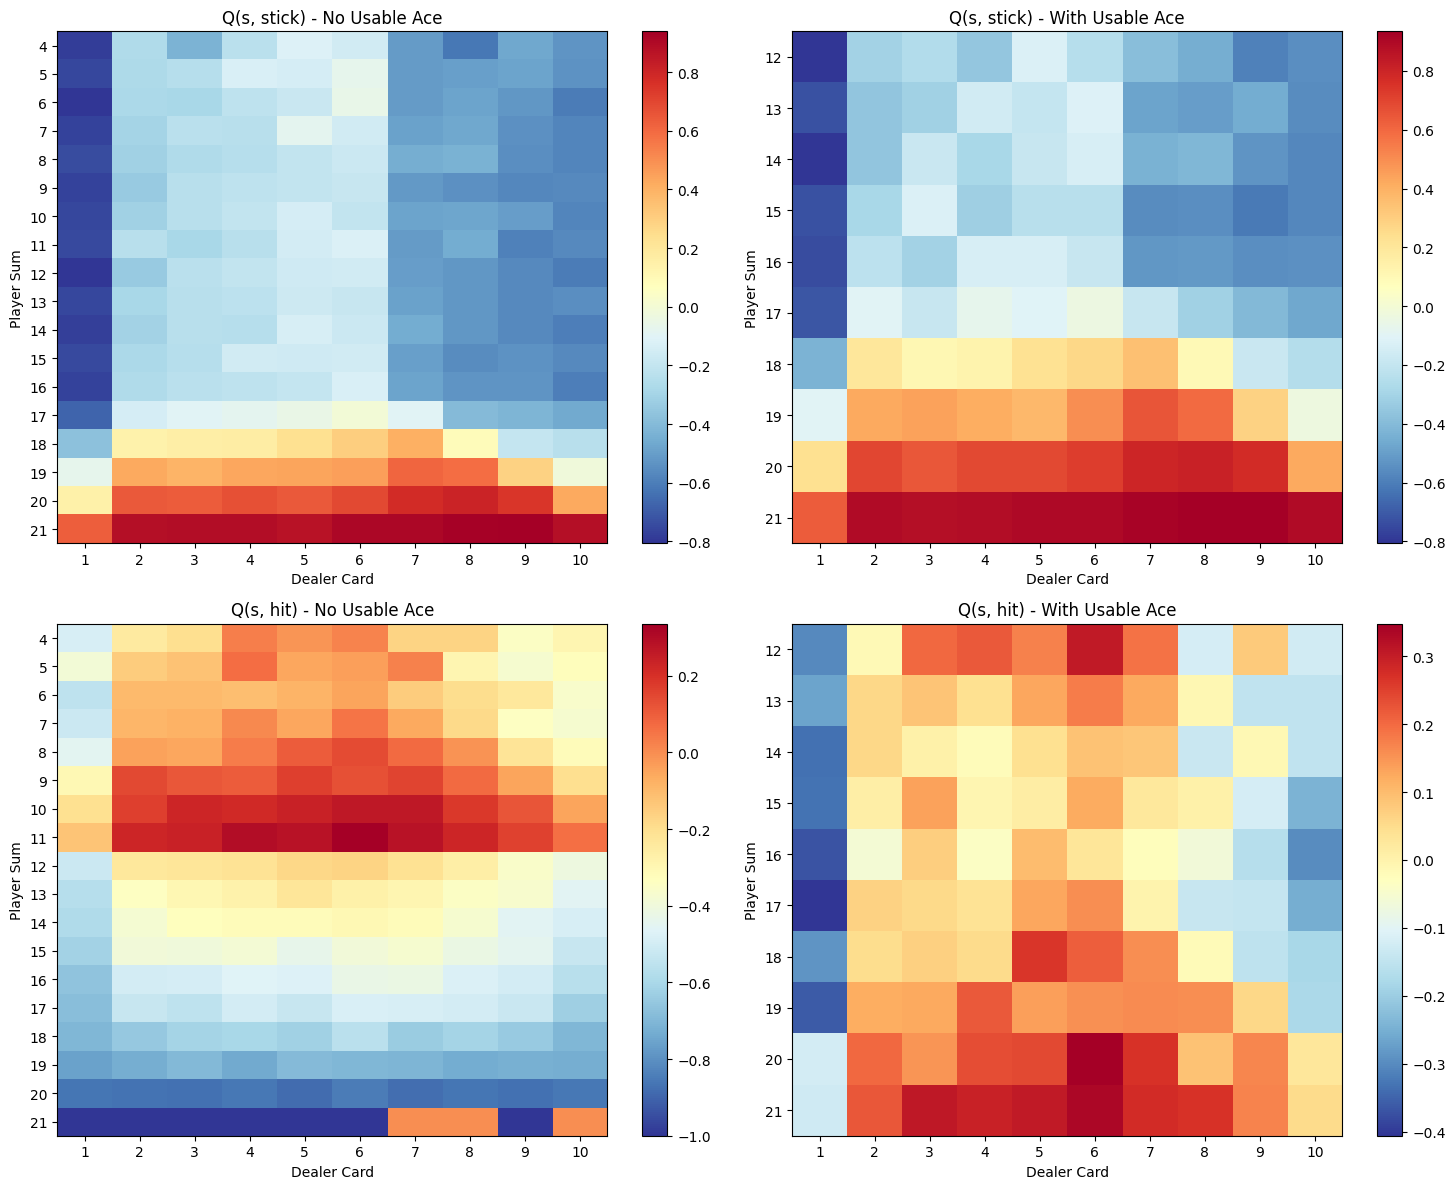

In [17]:
# Visualize the learned Q-values
print("Q-values heatmaps:")
plot_q_values(Q)


Optimal policy heatmaps:


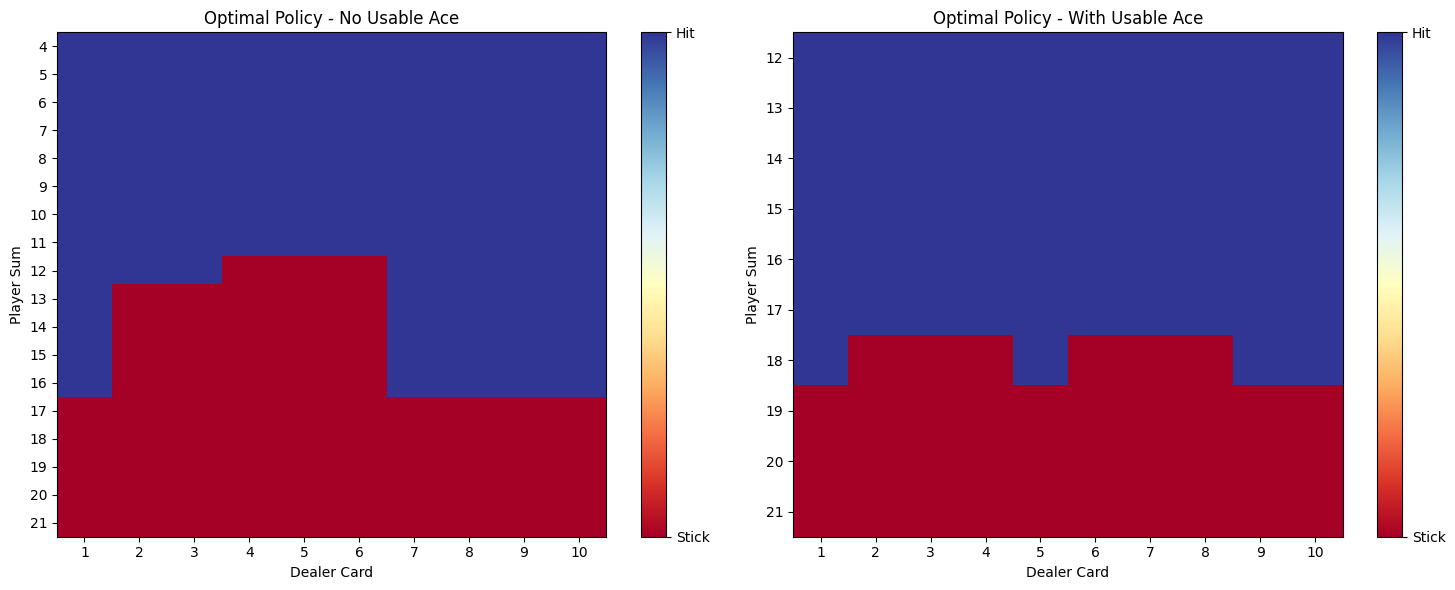

In [18]:
# Visualize the learned optimal policy
print("Optimal policy heatmaps:")
plot_policy(pi)


In [19]:
# Analyze the learned policy
def analyze_policy(pi):
    """
    Analyze the learned policy and print some insights.
    """
    print("Policy Analysis:")
    print("=" * 50)
    
    # Count actions by ace condition
    stick_no_ace = 0
    hit_no_ace = 0
    stick_ace = 0
    hit_ace = 0
    
    for state, action in pi.items():
        player_sum, dealer_card, usable_ace = state
        if usable_ace:
            if action == 0:
                stick_ace += 1
            else:
                hit_ace += 1
        else:
            if action == 0:
                stick_no_ace += 1
            else:
                hit_no_ace += 1
    
    total_no_ace = stick_no_ace + hit_no_ace
    total_ace = stick_ace + hit_ace
    
    print(f"Without usable ace: {stick_no_ace}/{total_no_ace} ({stick_no_ace/total_no_ace*100:.1f}%) stick")
    print(f"With usable ace: {stick_ace}/{total_ace} ({stick_ace/total_ace*100:.1f}%) stick")
    
    # Find some interesting policy decisions
    print("\nInteresting policy decisions:")
    print("-" * 30)
    
    # Look for cases where we stick with low sums
    low_sum_sticks = []
    for state, action in pi.items():
        player_sum, dealer_card, usable_ace = state
        if action == 0 and player_sum <= 16:  # stick with low sum
            low_sum_sticks.append((state, action))
    
    if low_sum_sticks:
        print("Cases where we stick with low sums:")
        for state, action in low_sum_sticks[:5]:
            print(f"  {state} -> stick")
    
    # Look for cases where we hit with high sums
    high_sum_hits = []
    for state, action in pi.items():
        player_sum, dealer_card, usable_ace = state
        if action == 1 and player_sum >= 18:  # hit with high sum
            high_sum_hits.append((state, action))
    
    if high_sum_hits:
        print("\nCases where we hit with high sums:")
        for state, action in high_sum_hits[:5]:
            print(f"  {state} -> hit")

analyze_policy(pi)


Policy Analysis:
Without usable ace: 73/180 (40.6%) stick
With usable ace: 36/100 (36.0%) stick

Interesting policy decisions:
------------------------------
Cases where we stick with low sums:
  (15, 5, 0) -> stick
  (13, 6, 0) -> stick
  (12, 6, 0) -> stick
  (14, 5, 0) -> stick
  (13, 2, 0) -> stick

Cases where we hit with high sums:
  (18, 10, 1) -> hit
  (18, 5, 1) -> hit
  (18, 9, 1) -> hit
  (18, 1, 1) -> hit
